# Read data

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import collections

from scipy.stats import chisquare
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import ks_2samp

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_weak_1_4 = pd.read_csv('weak/df.sim.weak.1.4.csv') 
data_weak_1_4 = data_weak_1_4.rename(columns={ data_weak_1_4.columns[0]: "Genes" })
data_weak_1_4 = data_weak_1_4.set_index("Genes")
data_weak_1_4 = data_weak_1_4.transpose() 
data_weak_1_4.head()

Genes,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene991,Gene992,Gene993,Gene994,Gene995,Gene996,Gene997,Gene998,Gene999,Gene1000
Cell1,6,55,48,48,8,7,2,0,2,0,...,6,17,575,75,14,133,1,71,4,0
Cell2,7,25,24,32,6,7,0,7,3,0,...,2,3,431,58,10,109,0,59,6,1
Cell3,20,26,10,54,2,1,4,0,7,1,...,3,10,622,45,11,146,0,61,2,1
Cell4,14,52,37,30,9,12,4,1,12,0,...,9,17,792,76,14,138,0,91,2,2
Cell5,9,39,26,32,1,3,0,0,18,0,...,3,18,555,50,3,89,2,41,4,1


In [3]:
data_mild_1_4 = pd.read_csv('mild/df.sim.mild.1.4.csv') 
data_mild_1_4 = data_mild_1_4.rename(columns={ data_mild_1_4.columns[0]: "Genes" })
data_mild_1_4 = data_mild_1_4.set_index("Genes")
data_mild_1_4 = data_mild_1_4.transpose() 
data_mild_1_4.head()

Genes,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene991,Gene992,Gene993,Gene994,Gene995,Gene996,Gene997,Gene998,Gene999,Gene1000
Cell1,10,61,36,52,2,15,0,0,0,0,...,6,1,804,36,25,142,0,77,0,2
Cell2,10,48,29,29,0,10,1,0,1,0,...,0,5,513,68,14,94,0,90,3,0
Cell3,11,59,36,43,15,3,8,0,1,0,...,8,20,564,34,7,187,0,48,0,3
Cell4,12,55,36,42,8,13,9,0,15,0,...,2,14,658,59,25,89,1,107,3,1
Cell5,12,43,37,45,6,2,2,0,11,0,...,3,4,539,97,30,108,0,71,2,3


In [4]:
data_strong_1_4 = pd.read_csv('strong/df.sim.strong.1.4.csv') 
data_strong_1_4 = data_strong_1_4.rename(columns={ data_strong_1_4.columns[0]: "Genes" })
data_strong_1_4 = data_strong_1_4.set_index("Genes")
data_strong_1_4 = data_strong_1_4.transpose() 
data_strong_1_4.head()

Genes,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene991,Gene992,Gene993,Gene994,Gene995,Gene996,Gene997,Gene998,Gene999,Gene1000
Cell1,12,74,40,52,8,11,0,0,0,0,...,1,5,513,65,13,98,2,69,5,0
Cell2,4,23,23,57,4,1,5,0,15,0,...,1,10,312,44,14,128,1,52,1,0
Cell3,13,54,42,49,3,13,3,0,4,0,...,2,11,444,51,37,141,1,58,4,0
Cell4,6,62,37,44,7,1,7,1,17,0,...,1,11,650,64,26,99,2,78,3,0
Cell5,17,66,37,41,6,2,0,0,9,0,...,7,11,548,51,15,141,0,64,1,1


In [5]:
n_batch1 = 100 #number of samples in batch 1
n_batch2 = 400 #number of samples in batch 2


batch_1 = [1 for i in range(n_batch1)]
batch_2 = [2 for i in range(n_batch2)]

#Assign the first n_batch1 samples to batch 1 and the next n_batch2 samples to batch 2
batch = batch_1 + batch_2
n_samples = len(batch)

# Apply $X^{2}$ test

In [6]:
def fdr_sample_qs(data, batch, sample_index, k = 30):
    
    """
    data= dataframe of gene experession data, rows are samples and columns are genes
    batch = list of batch labels corresponding to the samples in the data
    sample_index = the index of the sample that we want to find FDR of its neighborhood
    k = k nearest neighbors
    """
    
    #conver dataframe to array
    X = np.asarray(data)
    
    # find 50 first PCAs
    
    pca = PCA(n_components=50)
    PCs = pca.fit_transform(X)
    
    # k nearest neighbors of each PC
    
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(PCs)
    distances, indices = nbrs.kneighbors(PCs)
    
    #list of neighbors of sample s
    nbrs_of_s = indices[sample_index] 
    
    # what batches each neighbor of sample s belong to
    batches_nbrs_s = [batch[index] for index in list(nbrs_of_s)]

    # find frequency of each batch in nbrs_s
    counter=collections.Counter(batches_nbrs_s)
    freq_nbrs_s= list(counter.values())
    
    # find fraction of each batch in nbrs_s
    fractions_nbrs_s = [freq/sum(freq_nbrs_s) for freq in freq_nbrs_s]
    
    counter=collections.Counter(batch)
    n_samples = len(batch)
    n_batch_1 = counter[1]
    n_batch_2 = counter[2]

    counter=collections.Counter(batch)
    s, p = chisquare(f_obs = freq_nbrs_s,  f_exp =[k*n_batch_1/n_samples, k*n_batch_2/n_samples])
    
    #FDR_nbrs_s = 1.0-p
    
    #return FDR_nbrs_s
    return p

In [7]:
# false discovery rate
FDR_CHI_SQU ={}

# rejection rate
RR_CHI = {}
alpha = 0.05

In [8]:
# Weak

# list of p-value
p_CHI_weak = [fdr_sample_qs(data_weak_1_4, batch, i, k=20) for i in range(n_samples)]

# fdr
FDR_CHI_SQU["1_weak"] = 1-np.mean(p_CHI_weak)
print("FDR: ", FDR_CHI_SQU["1_weak"])

# rejection rate
RR_CHI["1_weak"] = sum(1 for i in p_CHI_weak if i<alpha)/len(p_CHI_weak)
print("RR: ", RR_CHI["1_weak"])

FDR:  0.8901058363189628
RR:  0.802


In [9]:
# Mild

# list of p-value
p_CHI_mild = [fdr_sample_qs(data_mild_1_4, batch, i, k=20) for i in range(n_samples)]

# fdr
FDR_CHI_SQU["2_mild"] = 1-np.mean(p_CHI_mild)
print("FDR: ", FDR_CHI_SQU["2_mild"])

# rejection rate
RR_CHI["2_mild"] = sum(1 for i in p_CHI_mild if i<alpha)/len(p_CHI_mild)
print("RR: ", RR_CHI["2_mild"])

FDR:  0.9838995349661156
RR:  0.968


In [10]:
# strong

# list of p-value
p_CHI_strong = [fdr_sample_qs(data_strong_1_4, batch, i, k=20) for i in range(n_samples)]

# fdr
FDR_CHI_SQU["3_strong"] = 1- np.mean(p_CHI_strong)
print("FDR: ", FDR_CHI_SQU["3_strong"])
      
# rejection rate
RR_CHI["3_strong"]= sum(1 for i in p_CHI_strong if i<alpha)/len(p_CHI_strong)
print("RR: ", RR_CHI["3_strong"])

FDR:  0.9999371534170537
RR:  1.0


# Apply Mann-Whitney U test

In [11]:
def fdr_sample_mw(data, batch, sample_index, k):
    
    """
    data= dataframe of gene experession data, rows are samples and columns are genes
    batch = list of batch labels corresponding to the samples in the data
    sample_index = the index of the sample that we want to find FDR of its neighborhood
    k = k nearest neighbors
    """
        
    # find 50 first PCAs
    pca = PCA(n_components=50)
    PCs = pca.fit_transform(data)
    
    # k nearest neighbors of each PC
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(PCs)
    distances, indices = nbrs.kneighbors(PCs)
    
    #list of neighbors of sample s
    nbrs_of_s = indices[sample_index] 
    
    # what batches each neighbor of sample s belong to
    batches_nbrs_s = [batch[index] for index in list(nbrs_of_s)]

    counter=collections.Counter(batch)
    n_samples = len(batch)
    n_batch_1 = counter[1]
    n_batch_2 = counter[2]
    
    # frequency of the overall dataset
    freq = [n_batch_1/n_samples, n_batch_2/n_samples]
    
    # frequency of the overall dataset with the length k
    expected_distr = [1 for i in range(round(k * freq[0]))] + [2 for i in range(round(k * freq[1]))]

    s, p = mannwhitneyu(batches_nbrs_s,  expected_distr)
    
    #FDR_nbrs_s = 1.0-p
    
    #return FDR_nbrs_s
    return p
    

In [12]:
# FDR
FDR_M_W = {}

# rejection rate
RR_M_W = {}
alpha = 0.05

In [13]:
p_M_W_weak = [fdr_sample_mw(data_weak_1_4, batch, i, k=20) for i in range(n_samples)]
FDR_M_W["1_weak"] = 1- np.mean(p_M_W_weak)
FDR_M_W["1_weak"]

0.6997885152887826

In [14]:
RR_M_W["1_weak"] = sum(1 for i in p_M_W_weak if i<alpha)/len(p_M_W_weak)
RR_M_W["1_weak"]

0.04

In [15]:
p_M_W_mild = [fdr_sample_mw(data_mild_1_4, batch, i, k=20) for i in range(n_samples)]
FDR_M_W["2_mild"] = 1-np.mean(p_M_W_mild)
FDR_M_W["2_mild"]

0.9302810815159182

In [16]:
RR_M_W["2_mild"] = sum(1 for i in p_M_W_mild if i<alpha)/len(p_M_W_mild)
RR_M_W["2_mild"]

0.662

In [17]:
p_M_W_strong = [fdr_sample_mw(data_strong_1_4, batch, i, k=20) for i in range(n_samples)]
FDR_M_W["3_strong"] = 1 - np.mean(p_M_W_strong)
FDR_M_W["3_strong"]

0.9830973644725807

In [18]:
RR_M_W["3_strong"] = sum(1 for i in p_M_W_strong if i<alpha)/len(p_M_W_strong)
RR_M_W["3_strong"]

0.988

# Apply Wilcoxon Signed-Rank test

In [19]:
def fdr_sample_w(data, batch, sample_index, k):
    
    """
    data= dataframe of gene experession data, rows are samples and columns are genes
    batch = list of batch labels corresponding to the samples in the data
    sample_index = the index of the sample that we want to find FDR of its neighborhood
    k = k nearest neighbors
    """
        
    # find 50 first PCAs
    pca = PCA(n_components=50)
    PCs = pca.fit_transform(data)
    
    # k nearest neighbors of each PC
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(PCs)
    distances, indices = nbrs.kneighbors(PCs)
    
    #list of neighbors of sample s
    nbrs_of_s = indices[sample_index] 
    
    # what batches each neighbor of sample s belong to
    batches_nbrs_s = [batch[index] for index in list(nbrs_of_s)]

    counter=collections.Counter(batch)
    n_samples = len(batch)
    n_batch_1 = counter[1]
    n_batch_2 = counter[2]
    
    # frequency of the overall dataset
    freq = [n_batch_1/n_samples, n_batch_2/n_samples]
    
    # frequency of the overall dataset with the length k
    expected_distr = [1 for i in range(round(k * freq[0]))] + [2 for i in range(round(k * freq[1]))]

    s, p = wilcoxon(batches_nbrs_s,  expected_distr)
    
    #FDR_nbrs_s = 1.0-p
    
    #return FDR_nbrs_s
    return p

In [20]:
# fdr
FDR_W = {}

# rejection rate
RR_W = {}
alpha = 0.05

In [21]:
p_W_weak = [fdr_sample_w(data_weak_1_4, batch, i, k=20) for i in range(n_samples)]

FDR_W["1_weak"] = 1- np.mean(p_W_weak)
FDR_W["1_weak"]

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/more

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

0.4113910852222491

In [22]:
RR_W["1_weak"] = sum(1 for i in p_W_weak if i<alpha)/len(p_W_weak)
RR_W["1_weak"]

0.03

In [23]:
p_W_mild = [fdr_sample_w(data_mild_1_4, batch, i, k=20) for i in range(n_samples)]
FDR_W["2_mild"] = 1- np.mean(p_W_mild)
FDR_W["2_mild"]

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/more

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/more

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/more

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/more

0.8584028433519226

In [24]:
RR_W["2_mild"] = sum(1 for i in p_W_mild if i<alpha)/len(p_W_mild)
RR_W["2_mild"]

0.648

In [25]:
p_W_strong = [fdr_sample_w(data_strong_1_4, batch, i, k=20) for i in range(n_samples)]

FDR_W["3_strong"] = 1 - np.mean(p_W_strong)
FDR_W["3_strong"]

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/ana

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/ana

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/ana

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculati

0.9618718905889698

In [26]:
RR_W["3_strong"] = sum(1 for i in p_W_strong if i<alpha)/len(p_W_strong)
RR_W["3_strong"]

0.986

# Kolmogorov-Smirnov's test

In [27]:
def fdr_sample_ks(data, batch, sample_index, k = 20):
    
    """
    data= data as array of gene experession data, rows are samples and columns are genes
    batch = list of batch labels corresponding to the samples in the data
    sample_index = the index of the sample that we want to find FDR of its neighborhood
    k = k nearest neighbors
    """
        
    # find 50 first PCAs
    pca = PCA(n_components=50)
    PCs = pca.fit_transform(data)
    
    # k nearest neighbors of each PC
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(PCs)
    distances, indices = nbrs.kneighbors(PCs)
    
    #list of neighbors of sample s
    nbrs_of_s = indices[sample_index] 
        
    # what batches each neighbor of sample s belong to
    batches_nbrs_s = [batch[index] for index in list(nbrs_of_s)]

    counter=collections.Counter(batch)
    n_samples = len(batch)
    n_batch_1 = counter[1]
    n_batch_2 = counter[2]
    
    # frequency of the overall dataset
    freq = [n_batch_1/n_samples, n_batch_2/n_samples]
    
    # frequency of the overall dataset with the length k
    expected_distr = [1 for i in range(round(k * freq[0]))] + [2 for i in range(round(k * freq[1]))]

    s, p = ks_2samp(batches_nbrs_s,  expected_distr)
    
    #FDR_nbrs_s = 1.0-p
    
    #return FDR_nbrs_s
    return p

In [28]:
# fdr
FDR_K_S = {}

# rejection rate
RR_K_S = {}
alpha = 0.05

In [29]:
p_K_S_weak = [fdr_sample_ks(data_weak_1_4, batch, i, k=20) for i in range(n_samples)]
FDR_K_S["1_weak"] = 1- np.mean(p_K_S_weak)
FDR_K_S["1_weak"]

0.012261218125434348

In [30]:
RR_K_S["1_weak"] = sum(1 for i in p_K_S_weak if i<alpha)/len(p_K_S_weak)
RR_K_S["1_weak"]

0.0

In [31]:
p_K_S_mild = [fdr_sample_ks(data_mild_1_4, batch, i, k=20) for i in range(n_samples)]
FDR_K_S["2_mild"] = 1-np.mean(p_K_S_mild)
FDR_K_S["2_mild"]

0.22951234984930402

In [32]:
RR_K_S["2_mild"] = sum(1 for i in p_K_S_mild if i<alpha)/len(p_K_S_mild)
RR_K_S["2_mild"]

0.096

In [33]:
p_K_S_strong = [fdr_sample_ks(data_strong_1_4, batch, i, k=20) for i in range(n_samples)]
FDR_K_S["3_strong"] = 1 - np.mean(p_K_S_strong)
FDR_K_S["3_strong"]

0.3290517636562422

In [34]:
RR_K_S["3_strong"] = sum(1 for i in p_K_S_strong if i<alpha)/len(p_K_S_strong)
RR_K_S["3_strong"]

0.192

# Visualization

Weak

In [35]:
#conver dataframe to array
X = np.asarray(data_weak_1_4)
pca = PCA(n_components=50)
X_embedded = pca.fit_transform(X)

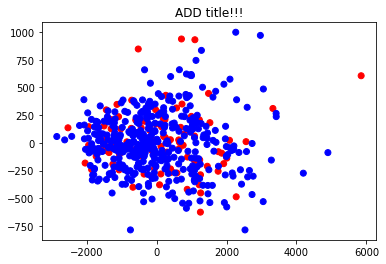

In [36]:
colors = {1:'red', 2:'blue'}
plt.title('ADD title!!!')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=[colors[x] for x in batch])

Mild

In [37]:
#conver dataframe to array
X = np.asarray(data_mild_1_4)
pca = PCA(n_components=50)
X_embedded = pca.fit_transform(X)

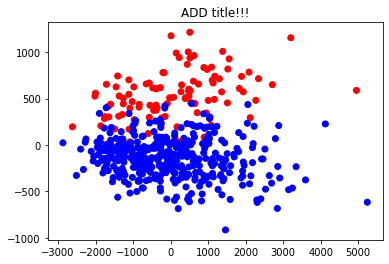

In [38]:
colors = {1:'red', 2:'blue'}
plt.title('ADD title!!!')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=[colors[x] for x in batch])

Strong

In [39]:
#conver dataframe to array
X = np.asarray(data_strong_1_4)
pca = PCA(n_components=50)
X_embedded = pca.fit_transform(X)

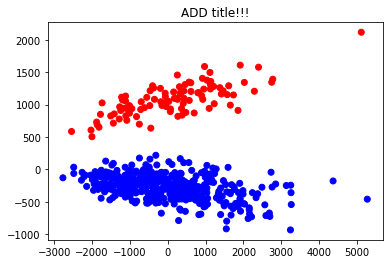

In [40]:
colors = {1:'red', 2:'blue'}
plt.title('ADD title!!!')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=[colors[x] for x in batch])

In [41]:
print(FDR_CHI_SQU)
print(FDR_M_W)
print(FDR_W)
print(FDR_K_S)

{'1_weak': 0.8901058363189628, '2_mild': 0.9838995349661156, '3_strong': 0.9999371534170537}
{'1_weak': 0.6997885152887826, '2_mild': 0.9302810815159182, '3_strong': 0.9830973644725807}
{'1_weak': 0.4113910852222491, '2_mild': 0.8584028433519226, '3_strong': 0.9618718905889698}
{'1_weak': 0.012261218125434348, '2_mild': 0.22951234984930402, '3_strong': 0.3290517636562422}


In [45]:
# merge dictionary
ds = [FDR_CHI_SQU, FDR_M_W, FDR_W, FDR_K_S]
d = {}
for k in FDR_CHI_SQU.keys():
  d[k] = tuple(d[k] for d in ds)

# convert dictionary to panda dataframe
FDR_result = pd.DataFrame.from_dict(d, orient='index',
                       columns=['FDR_CHI', 'FDR_M_W', 'FDR_W', 'FDR_K_S'])
# export to csv
FDR_result.to_csv('FDR_result_ratio_1_4.csv', index=True)
FDR_result

,FDR_CHI,FDR_M_W,FDR_W,FDR_K_S
1_weak,0.890106,0.699789,0.411391,0.012261
2_mild,0.983900,0.930281,0.858403,0.229512
3_strong,0.999937,0.983097,0.961872,0.329052


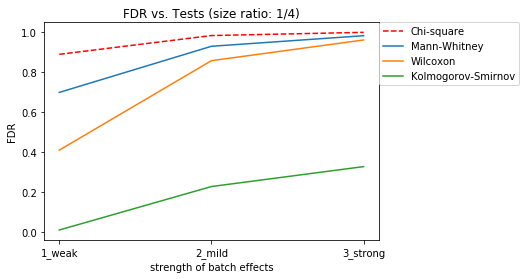

In [48]:
plt.plot(*zip(*sorted(FDR_CHI_SQU.items())), '--r', label= 'Chi-square')
plt.plot(*zip(*sorted(FDR_M_W.items())), label = 'Mann-Whitney' )
plt.plot(*zip(*sorted(FDR_W.items())), label = 'Wilcoxon')
plt.plot(*zip(*sorted(FDR_K_S.items())), label = 'Kolmogorov-Smirnov')
#plt.ylim(0,1)
plt.xlabel ('strength of batch effects')
plt.ylabel ('FDR')
#plt.xticks(list(keys))
#plt.legend (bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)
plt.title('FDR vs. Tests (size ratio: 1/4)')
plt.legend (bbox_to_anchor=(1, 1), loc="best", borderaxespad=0.)
plt.show()

In [43]:
print(RR_CHI)
print(RR_M_W)
print(RR_W)
print(RR_K_S)

{'1_weak': 0.802, '2_mild': 0.968, '3_strong': 1.0}
{'1_weak': 0.04, '2_mild': 0.662, '3_strong': 0.988}
{'1_weak': 0.03, '2_mild': 0.648, '3_strong': 0.986}
{'1_weak': 0.0, '2_mild': 0.096, '3_strong': 0.192}


In [46]:
# merge dictionary
ds = [RR_CHI, RR_M_W, RR_W, RR_K_S]
d = {}
for k in RR_CHI.keys():
  d[k] = tuple(d[k] for d in ds)

# convert dictionary to panda dataframe
RR_result = pd.DataFrame.from_dict(d, orient='index',
                       columns=['RR_CHI', 'RR_M_W', 'RR_W', 'RR_K_S'])

# export to csv
RR_result.to_csv('RR_result_ratio_1_4.csv', index=True)
RR_result

,RR_CHI,RR_M_W,RR_W,RR_K_S
1_weak,0.802,0.040,0.030,0.000
2_mild,0.968,0.662,0.648,0.096
3_strong,1.000,0.988,0.986,0.192


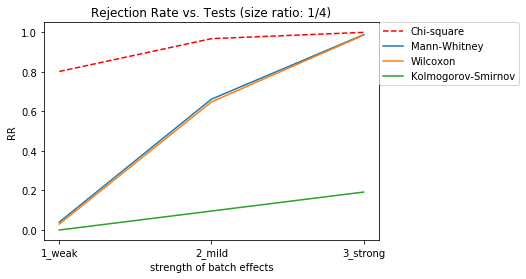

In [47]:
plt.plot(*zip(*sorted(RR_CHI.items())), '--r', label= 'Chi-square')
plt.plot(*zip(*sorted(RR_M_W.items())), label = 'Mann-Whitney' )
plt.plot(*zip(*sorted(RR_W.items())), label = 'Wilcoxon')
plt.plot(*zip(*sorted(RR_K_S.items())), label = 'Kolmogorov-Smirnov')
#plt.ylim(0,1)
plt.xlabel ('strength of batch effects')
plt.ylabel ('RR')
#plt.xticks(list(keys))
#plt.legend (bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)
plt.title('Rejection Rate vs. Tests (size ratio: 1/4)')
plt.legend (bbox_to_anchor=(1, 1), loc="best", borderaxespad=0.)
plt.show()